# Analysing temperature measurements in an animal shelter

Once the temerature mesurements have been retrived as a .csv file they can be processed and analysed with pandas and matplotlib.pyplot.

We will first import these two libraries.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

We will than load the .csv file and perform Exploratory Data Analysis (EDA).

In [3]:
df = pd.read_csv('Stats.csv', header=None) 
# as the file contains no header row, we will block automatinc inference of column names

EDA is understanding data sets through their main characteristics and plotting them visually. The main EDA objectives of this project are:
* Describing the data set - preview of the data set, infering the number of rows/columns, data types, and possible missing data; 
* Tidying and cleaning the data set - handle missing data and incorrect values;
* Visualising data. 

## Describing the data set

First, we would like to take a look at the data set to see how the data presents itself and define our strategy.

In [4]:
df.head() # visualise the first 5 rows of the DataFrame

,0,1,2
0,2019-06-30 18:42:12,92,29.1
1,2019-06-30 18:42:12,92,29.1
2,2019-06-30 18:42:20,30,28.7
3,2019-06-30 18:42:20,30,28.7
4,2019-06-30 18:42:26,12,28.7


In [5]:
df.tail() # visualise the last 5 rows of the DataFrame

,0,1,2
2801861,2019-12-09 17:24:45,12,26.2
2801862,2019-12-09 17:24:47,30,21.3
2801863,2019-12-09 17:24:47,30,21.3
2801864,2019-12-09 17:24:54,92,18.2
2801865,2019-12-09 17:24:54,92,18.2


In [6]:
df.shape # the raw data set has 2801866 rows and 3 columns

(2801866, 3)

We notice that the data is arranged into 3 columns: the "0" column includes the data stamp of the temperature measurement, the "1" column includes the thermometre id in by room and the last column, "2", includes the respective temperature reading. 

Therefore, we can rename the columns as *"Date"*, *"id"*, and *"Temp"*. 

In [7]:
df.columns = ['Date', 'id', 'Temp']

Next, it is interesting to check the type of the data we have in the data set and change this where necessary.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2801866 entries, 0 to 2801865
Data columns (total 3 columns):
Date    object
id      int64
Temp    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 64.1+ MB


We observe here that *"Date"* is classified as an *object* and the *"id"* as an *integer"* and should proceed to changing the data type of these two columns to *datetime* and to *category*, respectively. 

In [9]:
df['Date'] = pd.to_datetime(df['Date'])

In [10]:
df['id']=df['id'].astype('category')

Setting the *"id"* as a *category* type alse reduces memory usage from 64.1+ MB to 45.4 MB.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2801866 entries, 0 to 2801865
Data columns (total 3 columns):
Date    datetime64[ns]
id      category
Temp    float64
dtypes: category(1), datetime64[ns](1), float64(1)
memory usage: 45.4 MB


Next, we should check to see if there are any missing values in the data set. 

In [12]:
df.isnull().sum()

Date    0
id      0
Temp    0
dtype: int64

There does not seem to be any, but something still does not seem right when we look at the top 5 first and last rows. Indeed, we notice that rows 1 and 2 are identical, and so are rows 3 and 4. Therefore, we need to drop the duplicate measurements.

In [13]:
df.drop_duplicates(inplace=True) 

The number of rows in the data set thus dropped from 2801866 to 1590738.

In [14]:
df.shape

(1590738, 3)

## Tidying and cleaning the data set

The next stage is to tidy and clean the data set. 

The thermometers were taking measurements on regular intervals of one minute. This order of detail of data is probably excessively meticulous for further analysis and will take more computational power than it can be justified. A good compromise would be to round up the measurements to hourly intervals. 

In [15]:
df = df.set_index('Date') 
# set a datetime index

In [16]:
df = df.groupby('id').resample('H').mean() 
# resample by id to obtain the hourly mean

Given that the *"id"* column registers the measurements by different rooms, it would be interesting to see if the there are any missing or currupt values by room. 

For this, we need first to reset the index than pivot our DataFrame. 

In [17]:
df = df.reset_index() 
# reset the index to be able to rearrange the table 

In [18]:
df = df.pivot(index='Date', columns='id', values='Temp') 
# arrange the hourly temperature by id

In [19]:
df.isnull().sum() 
# check for missing values 

id
3       14
11      14
12      14
30      14
64      14
68    3887
92      13
dtype: int64

In [20]:
df.shape

(3888, 7)

We notice that the room with the id "68" contains only one value. This might be related to a technical bug or a restart of the thermometre which probably allocated the measurements to another id at later periods. Thefore, the column related to the id "68" can be dropped altogher without any significant loss of data in the data set. 

We equally notice missing data for other rooms which we will address later.

In [21]:
index_df = df.index.to_frame(index=False)
# substract the datetime index to be able to reset the CategoricalIndex columns

In [22]:
df = df.reset_index(drop=True)
# reset the CategoricalIndex columns

In [23]:
df = pd.merge(index_df, df, left_index=True, right_index=True)
# merge the two DataFrames

In [24]:
df.columns = ['Date', 'rue_gauche', 'couloir_bas', 'chambre_droite', 'rue_droite', 'cuisine', 'valeurs_absentes', 'sdb']
# rename the columns

In [25]:
df = df.drop(columns = 'valeurs_absentes') # drop the column with missing values

In [26]:
df['Date'] = pd.to_datetime(df['Date'])

In [27]:
df = df.set_index('Date') # set a datetime index

Check the "rearranged" data set before adressing the remaining missing values.

In [28]:
df.head()

,rue_gauche,couloir_bas,chambre_droite,rue_droite,cuisine,sdb
Date,,,,,,
2019-06-30 18:00:00,29.240909,27.944444,28.700000,28.931818,28.561905,29.461905
2019-06-30 19:00:00,29.061972,27.428358,28.497015,28.730303,28.230882,29.377419
2019-06-30 20:00:00,28.990000,27.160606,28.112121,28.779412,28.084286,29.310000
2019-06-30 21:00:00,29.200000,27.100000,28.208824,28.949231,28.200000,29.407353
2019-06-30 22:00:00,29.200000,27.457353,28.155714,28.653425,28.292754,29.329508


There are between 13 and 14 missing values for each room.

In [29]:
df.isnull().sum()

rue_gauche        14
couloir_bas       14
chambre_droite    14
rue_droite        14
cuisine           14
sdb               13
dtype: int64

In order to decide how to resolve the missing values, we need to identify at which moment in time and at which intervals the data is missing. 

Using the *"loc"* method, we check for different time intervals and see that 2 data points are missing for September and between 11 and 12 data points are missing for December, most of them missing for the day before the last day of measurements in the data set.

In [30]:
df.loc['2019-09-01':'2019-09-30'].isnull().sum()
# 2 missing values have been identified for September

rue_gauche        2
couloir_bas       2
chambre_droite    2
rue_droite        2
cuisine           2
sdb               2
dtype: int64

In [31]:
df.tail() 
# check the last registered values

,rue_gauche,couloir_bas,chambre_droite,rue_droite,cuisine,sdb
Date,,,,,,
2019-12-09 13:00:00,19.577273,18.330435,21.500000,20.252857,19.370423,18.907143
2019-12-09 14:00:00,17.371014,16.463235,18.612676,19.305479,17.809859,18.583871
2019-12-09 15:00:00,17.895714,15.810294,17.718056,19.508451,18.116901,18.334375
2019-12-09 16:00:00,19.516667,16.400000,18.441270,20.053030,18.804615,18.852542
2019-12-09 17:00:00,20.400000,18.370000,25.438889,21.150000,19.370588,18.522222


In [32]:
df.loc['2019-12-01':'2019-12-09'].isnull().sum() 
# between 11 and 12 missing values have been identified for December 

rue_gauche        12
couloir_bas       12
chambre_droite    12
rue_droite        12
cuisine           12
sdb               11
dtype: int64

In [33]:
df.loc['2019-12-08'].isnull().sum() 
# most of them are for the day before last day of measurements in the data set

rue_gauche        11
couloir_bas       11
chambre_droite    11
rue_droite        11
cuisine           11
sdb               11
dtype: int64

As there is a significant number of missing values during the last 2 days of measurements and these missing values are consistent among all rooms, we can drop the last 2 days of measurements in the data set.

In [34]:
df = df.loc['2019-06-30 18:00:00':'2019-12-08 05:00:00'] 

For the remaining 3 missing values, given that the measurement are provided at hourly intervals we can decide to address them via forward fill. 

In [35]:
df = df.fillna(method='ffill')

Thus all the missing values have been solved, the datatset is clean and ready to be visualised.

In [36]:
df.isnull().sum()

rue_gauche        0
couloir_bas       0
chambre_droite    0
rue_droite        0
cuisine           0
sdb               0
dtype: int64

## Visualising data

Now that the data set has been cleaned and prepared for analysis we can proceed to data visualisation. 

It is good to get a first glimpse at all the data, if possible, in order to understand what visualisation techniques are better suited to present the information. 

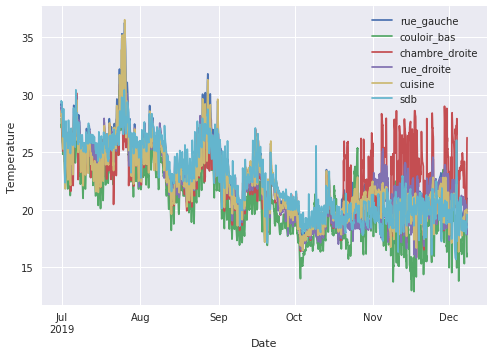

In [38]:
with plt.style.context('seaborn'):
    df.plot()
    plt.ylabel("Temperature")

While we can see the measurements in great details and can infer which room registers most variation, what are the gobal maximum and minim temperature, the day-night temperature variations impede us from seizing more information at a glance.

A way to solve these variations is implementing moving average on time series data. For this project, *Simple Moving Average* (SMA) for 24 hours window periods have been computed for each room temperature measurements. 

In [39]:
df['rue_gauche_SMA_24'] = df.iloc[:,0].rolling(window=24).mean()
df['couloir_bas_SMA_24'] = df.iloc[:,1].rolling(window=24).mean()
df['chambre_droite_SMA_24'] = df.iloc[:,2].rolling(window=24).mean()
df['rue_droite_SMA_24'] = df.iloc[:,3].rolling(window=24).mean()
df['cuisine_SMA_24'] = df.iloc[:,4].rolling(window=24).mean()
df['sdb_SMA_24'] = df.iloc[:,5].rolling(window=24).mean()

In the graph below we can see the difference by looking at the hourly temperature measurements for the entire period and the implemented SMA.

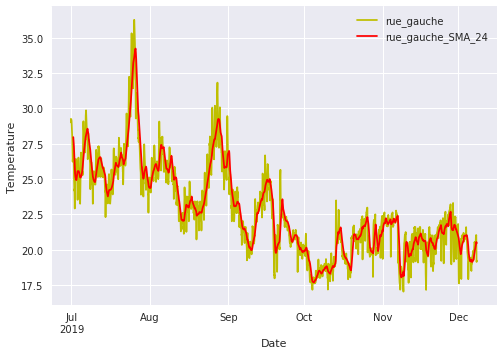

In [41]:
with plt.style.context('seaborn'):
    df['rue_gauche'].plot(color='y')
    df['rue_gauche_SMA_24'].plot(color='r')
    plt.ylabel("Temperature")
    plt.legend()

We can also group temperature measurements for the entire period for different parts of the animal shelter and check for disparities.

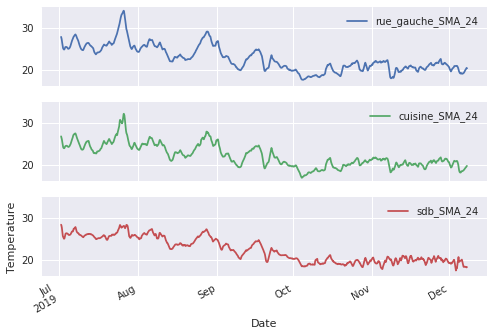

In [42]:
with plt.style.context('seaborn'):
    df[['rue_gauche_SMA_24','cuisine_SMA_24','sdb_SMA_24']].plot(subplots=True, sharex=True, sharey=True)
    plt.ylabel("Temperature")
    # temperature measurements in the left wing of the building

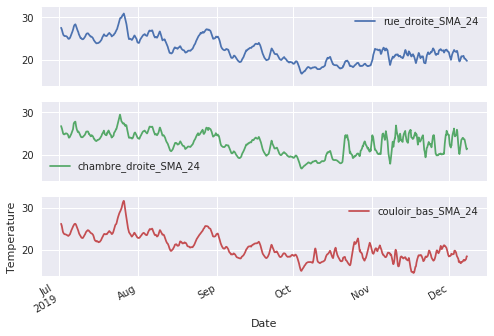

In [43]:
with plt.style.context('seaborn'):
    df[['rue_droite_SMA_24','chambre_droite_SMA_24','couloir_bas_SMA_24']].plot(subplots=True, sharex=True, sharey=True,)
    plt.ylabel("Temperature")
    # temperature measurements in the right wing of the building and on the ground floor

Another option is exploring variations in temperature in each room of the animal shelter for each month of the monitoring period. 

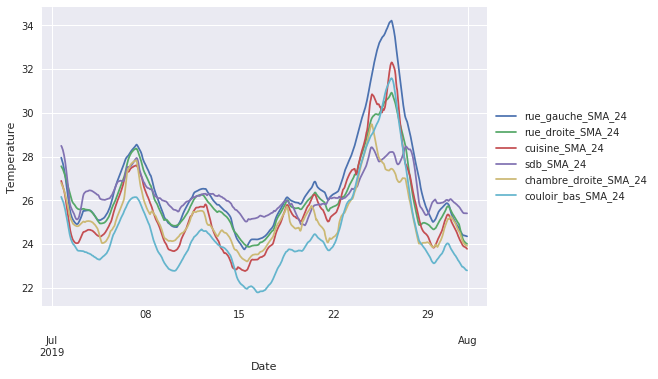

In [44]:
with plt.style.context('seaborn'):
    df.loc['2019-07', ['rue_gauche_SMA_24','rue_droite_SMA_24',
                       'cuisine_SMA_24','sdb_SMA_24','chambre_droite_SMA_24',
                       'couloir_bas_SMA_24']].plot()
    plt.ylabel("Temperature")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    # Temperature measurements for the month of July

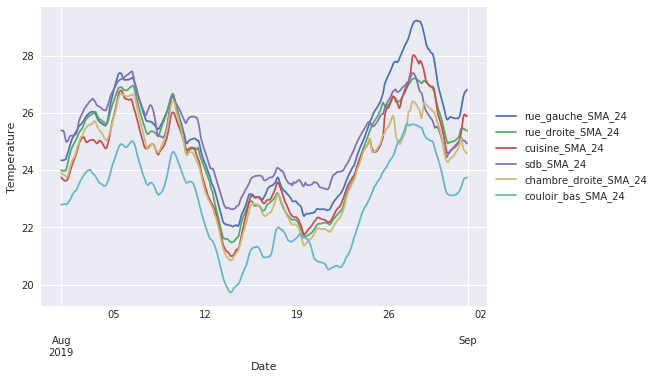

In [45]:
with plt.style.context('seaborn'):
    df.loc['2019-08', ['rue_gauche_SMA_24','rue_droite_SMA_24',
                       'cuisine_SMA_24','sdb_SMA_24',
                       'chambre_droite_SMA_24','couloir_bas_SMA_24']].plot()
    plt.ylabel("Temperature")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    # Temperature measurements for the month of August

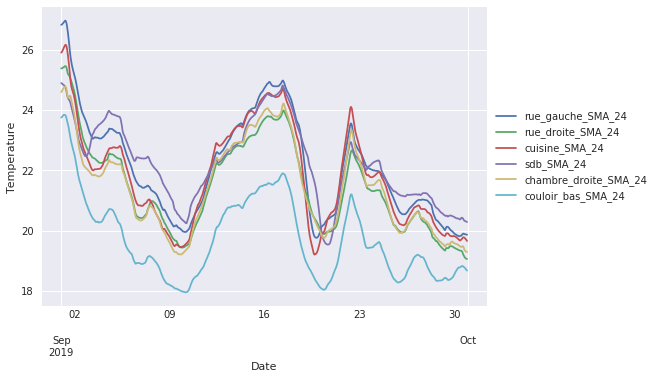

In [46]:
with plt.style.context('seaborn'):
    df.loc['2019-09', ['rue_gauche_SMA_24','rue_droite_SMA_24',
                       'cuisine_SMA_24','sdb_SMA_24',
                       'chambre_droite_SMA_24','couloir_bas_SMA_24']].plot()
    plt.ylabel("Temperature")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    # Temperature measurements for the month of September

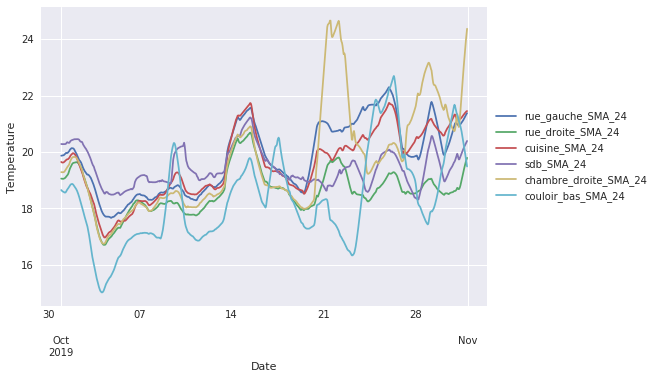

In [47]:
with plt.style.context('seaborn'):
    df.loc['2019-10', ['rue_gauche_SMA_24','rue_droite_SMA_24',
                       'cuisine_SMA_24','sdb_SMA_24',
                       'chambre_droite_SMA_24','couloir_bas_SMA_24']].plot()
    plt.ylabel("Temperature")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    # Temperature measurements for the month of October

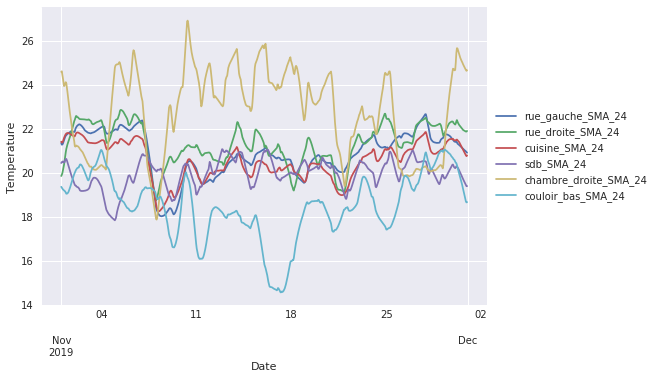

In [49]:
with plt.style.context('seaborn'):
    df.loc['2019-11', ['rue_gauche_SMA_24','rue_droite_SMA_24',
                       'cuisine_SMA_24','sdb_SMA_24',
                       'chambre_droite_SMA_24','couloir_bas_SMA_24']].plot()
    plt.ylabel("Temperature")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    # Temperature measurements for the month of November

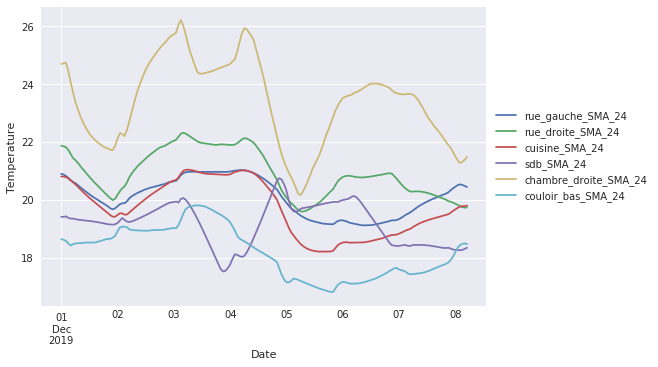

In [50]:
with plt.style.context('seaborn'):
    df.loc['2019-12', ['rue_gauche_SMA_24','rue_droite_SMA_24',
                       'cuisine_SMA_24','sdb_SMA_24',
                       'chambre_droite_SMA_24','couloir_bas_SMA_24']].plot()
    plt.ylabel("Temperature")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    # Temperature measurements for the month of December

These graphs allow to quickly infer the A/C and heating system management and implement corrective measures in the folloving period.